In [1]:
import cmath
import numpy as np

c = 3000.

# source
x = 0.
y = 0.
z = 0.
r_0 = np.array([x,y,z])
f = 5. # Hz frequency

# anomaly
x_0 = 500.
y_0 = -150.
z_0 = 300.
S = 300.
beta = 0.5
N = 10 # sampling

# receivers
xRec_1 = 500
xRec_k = 1500
k = 50

def green_func(r, r_0):
    alpha = 2.*cmath.pi*f*1j/c
    return cmath.exp(alpha*np.linalg.norm(r-r_0))/(4*cmath.pi*np.linalg.norm(r-r_0))

samples = np.empty([1, 3])

deltaS = (1/(c**2))*(1/(1+beta)**2 - 1)

K = np.array([])
for N_1 in range(0, N):
    for N_2 in range(0,N):
        for N_3 in range(0,N):
            r = np.array([x_0 + (N_1+.5)*(S/N), y_0 + (N_2+.5)*(S/N), z_0+(N_3+.5)*(S/N)])
            samples = np.vstack([samples,r])
            K = np.append(K, green_func(r,r_0))
            
P_i = np.array(K, copy = True)
            
K = (2*cmath.pi*f)**2*(S/N)**3*K*deltaS 

In [2]:
R = np.array([])
for i in range(0, k):
    Sum = 0
    for j in range(0, N**3):
        Sum  = Sum + K[j]*green_func(samples[j+1], np.array([xRec_1+i*(xRec_k - xRec_1)/k,0,0]))
    R = np.append(R, Sum)

In [3]:
G = np.zeros((N**3,N**3), dtype=np.complex)
for i in range(0, N**3):
    for j in range(0, N**3):
        if i < j:
            u = green_func(samples[i+1], samples[j+1])
            G[i][j] = u
            G[j][i] = u
P_b = np.dot(G, K)

In [4]:
lamb_qa =  P_i/(P_i - P_b)
R_qa = np.array([])
for i in range(0, k):
    Sum = 0
    for j in range(0, N**3):
        Sum  = Sum + K[j]*lamb_qa[j]*green_func(samples[j+1], np.array([xRec_1+i*(xRec_k - xRec_1)/k,0,0]))
    R_qa = np.append(R_qa, Sum)

In [5]:
A = (2 * cmath.pi * f)**2 * (S/N)**3 * deltaS * np.dot(G, np.diag(P_i)) 
lamb_ql = np.linalg.solve(A-np.diag(P_i), - np.dot(A,np.ones(A[1].size)))

In [6]:
R_ql = np.array([])
for i in range(0, k):
    Sum = 0
    for j in range(0, N**3):
        Sum  = Sum + K[j]*(1+lamb_ql[j])*green_func(samples[j+1], np.array([xRec_1+i*(xRec_k - xRec_1)/k,0,0]))
    R_ql = np.append(R_ql, Sum)

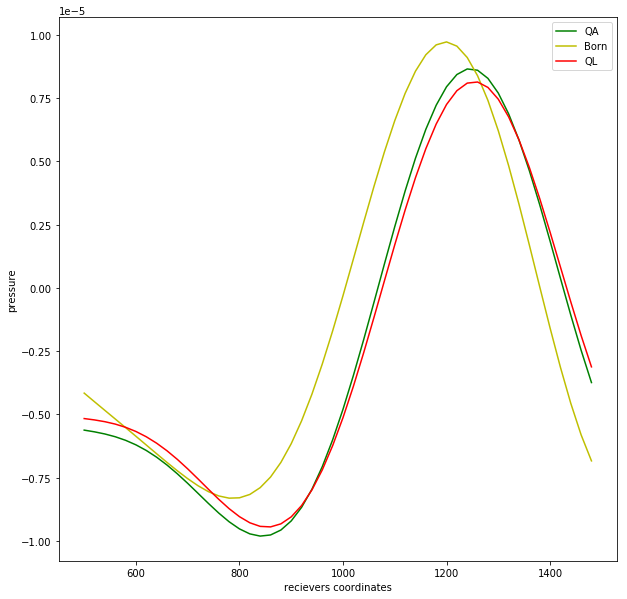

In [11]:
import matplotlib.pyplot as plt
#import matplotlib.cm as cm

plt.figure(figsize=(10, 10))
plt.xlabel('recievers coordinates')
plt.ylabel('pressure')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

x = np.array([])
y_QA = np.array([])
y_born = np.array([])
y_QL = np.array([])
for j in range(0,R.size):
    x = np.append(x, xRec_1+j*((xRec_k - xRec_1)/k))
    y_QA = np.append(y_QA, R_qa[j])
    y_born = np.append(y_born, R[j])
    y_QL = np.append(y_QL, R_ql[j])
plt.plot(x , y_QA, 'g-', label='QA')
plt.plot(x , y_born, 'y-', label = 'Born')
plt.plot(x , y_QL, 'r-', label = 'QL')
plt.legend()
plt.show()